In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import c, k_B, M_sun, G, m_p, sigma_sb, m_p
import astropy.units as u
from scipy.sparse import csr_matrix
from scipy.optimize import fsolve, differential_evolution, minimize
import numpy as np
import numba
import sys

sys.path.append('../Numerical_methods')
from bachelor_funcs import Σ_initial, c_s2
from unchanged_values import r_au, sD1_log, Ω, T_req

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)

## Disc wind mass flux $C_W$
### $C_{w,e}$ Disc wind mass flux constrained by energetics
$$C_{w,e}=max\left(\frac{2}{r^3\Omega(\rho c_s)_{mid}}\partial_r(r^2\Sigma\alpha_{r\phi}c_s^2)\;+\;\frac{2c_s},\;0\right)$$
$$(\rho c_s)_{mid} = \frac{1}{\sqrt{2\pi}}\Sigma \Omega$$
### $C_{w,0}$ A constant size constrained by the density at the midplane $\alpha_{r\phi}$
*For MRI-inactive $\alpha_{r\phi} = 8\cdot10^{-5}$:*
$$C_{w,0}=10^{-5}$$

$$C_W = \text{min}(C_{w,0},\;C_{w,e})$$

# Disc wind torque $\alpha_{\phi z}$
### Zero-torque:
$$\alpha_{\phi z}=0$$
### Constant-torque:
$$\alpha_{\phi z} = 10^{-4}$$
### $\Sigma$-dependent torque:
$$\alpha_{\phi z} = \text{min}\left(10^{-5}\left(\frac{\Sigma}{\Sigma_{int}}\right)^{-0.66},\;1\right)$$

In [22]:
def α_φz_func(Σ):
    Σ_relation = 1e-5 * (Σ / Σ_initial(r_au))**(-0.66)
    Σ_relation[Σ_relation >= 1] = 1
    return Σ_relation

In [23]:
def ρ_cs_mid(Σ):
    return ((2 * np.pi)**(-0.5) * Σ * Ω).decompose()   

In [24]:
ρ_cs_mid(Σ_initial(r_au))

<Quantity [1.34983884e+004, 1.09602195e+004, 8.89929976e+003,
           7.22589451e+003, 5.86714118e+003, 4.76387699e+003,
           3.86806311e+003, 3.14069313e+003, 2.55009479e+003,
           2.07055097e+003, 1.68118004e+003, 1.36502664e+003,
           1.10832347e+003, 8.99891866e+002, 7.30655071e+002,
           5.93243016e+002, 4.81671430e+002, 3.91081274e+002,
           3.17527163e+002, 2.57805578e+002, 2.09315373e+002,
           1.69944512e+002, 1.37978101e+002, 1.12023714e+002,
           9.09507579e+001, 7.38412408e+001, 5.99497932e+001,
           4.86712107e+001, 3.95140968e+001, 3.20794633e+001,
           2.60433532e+001, 2.11427321e+001, 1.71640316e+001,
           1.39338480e+001, 1.13113888e+001, 9.18234060e+000,
           7.45388927e+000, 6.05067712e+000, 4.91151994e+000,
           3.98674154e+000, 3.23600949e+000, 2.62657783e+000,
           2.13186028e+000, 1.73027173e+000, 1.40428764e+000,
           1.13968026e+000, 9.24898562e-001, 7.50564760e-001,
        

In [25]:
α_rφ = 8e-5
ρ_cs_mid(Σ_initial(r_au))
def part1(Σ):
    return 2 * ((r_au**3 * Ω * ρ_cs_mid(Σ))**(-1)).decompose()

def part2(Σ, T):
    to_dev = (r_au**2 * Σ * α_rφ * c_s2(T)).decompose()
    return (r_au**(-1) * (sD1_log @ to_dev) * to_dev.unit).decompose()

def part3(T, α_φz):
    return ((2 * np.sqrt(c_s2(T))) / (r_au * Ω) * α_φz).decompose()

C = part1(Σ_initial(r_au)) * part2(Σ_initial(r_au), T_req) + part3(T_req, 1e-5)


In [26]:
def C_we(Σ, T, α_φz):
    def part1(Σ):
        return 2 * ((r_au**3 * Ω * ρ_cs_mid(Σ))**(-1)).decompose()

    def part2(Σ, T):
        to_dev = (r_au**2 * Σ * α_rφ * c_s2(T)).decompose()
        return (r_au**(-1) * (sD1_log @ to_dev) * to_dev.unit).decompose()

    def part3(T, α_φz):
        return ((2 * np.sqrt(c_s2(T))) / (r_au * Ω) * α_φz).decompose()
    
    C_we = (part1(Σ) * part2(Σ, T) + part3(T, α_φz)).value
    C_we[C_we < 0] = 0

    return C_we    

In [ ]:
def C_w(Cw0, Cwe):
    C_W = Cw0 * np.ones_like(r_au)
    C_W[C_W > Cwe] = Cwe
    return C_W

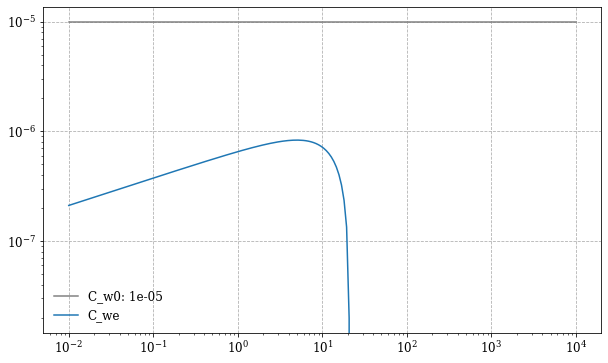

In [29]:
fig, axs = plt.subplots(figsize = (10, 6))
axs.grid(ls='--')

axs.loglog(r_au, 1e-5 * np.ones_like(r_au), c='grey', label = f'C_w0: {1e-5}')
axs.loglog(r_au, C_we(Σ_initial(r_au), T_req, 1e-5), label= f'C_we')


plt.legend(frameon=False)